# CM3070 Final Project, Exploratory Data Analysis

```
University of London
BSc Computer Science
CM3070, Final Project
Hudson Leonardo MENDES
hlm12@student.london.ac.uk
```


## 1. Environment


### 1.1. Dependencies


In [1]:
!cat ../setup.cfg

[metadata]
name = hlm12erc
version = attr: hlm12erc.VERSION
author = Hudson Mendes
author_email = hlm12@student.london.ac.uk
description = Final Project from University of London
long_description = file: README.md, LICENSE
keywords = university-of-london
license = copyright

[options]
zip_safe = False
include_package_data = True
packages = find:
package_dir =
    =src
python_requires = >=3.10
install_requires =
    torch>=2.0.1
    torchtext>=0.15.2
    torchvision>=0.15.2
    transformers>=4.30.2
    nltk>=3.8.1
    Pillow>=10.0.0
    scikit-learn>=1.3.0

[options.package_data]

[options.extras_require]
# development
dev =
    pre-commit>=3.3.3
    black[jupyter]>=23.7.0
    isort>=5.12.0

test =
    pytest>=7.4.0

# mlops
etl =
    # extract, transformation & loading
    kaggle>=1.5.13
    tqdm>=4.65.0
    pandas>=2.0.1
    google-cloud-storage>=2.10.0
    moviepy>=1.0.3

eda =
    # exploratory data analysis, and model design
    gensim
    tensorflow
    tensorflow-hub
    torch
  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging

logging.basicConfig(level=logging.INFO)

In [4]:
import nltk

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hudsonmendes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hudsonmendes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1.2. Paths & Locations

In [5]:
import pathlib

dir_data = pathlib.Path("../data")

## 2. Extraction, Transformation & Load


In [6]:
%%capture
%pip install -e '..[etl]'

In [7]:
from hlm12erc.etl import ETL, KaggleDataset

ds_kaggle = KaggleDataset(owner="zaber666", name="meld-dataset", subdir="MELD-RAW/MELD.Raw")
etl = ETL(dataset=ds_kaggle).into(uri_or_folderpath=dir_data)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:hlm12erc.etl:Kaggle dataset: zaber666/meld-dataset
INFO:hlm12erc.etl:Workspace set to: /tmp/hlm12erc/etl
INFO:hlm12erc.etl:Dataset already loaded into ../data, skipping (use force=True to force re-load).


In [8]:
!ls {str(dir_data)} | head -n 10

d-0-seq-0.png
d-0-seq-0.wav
d-0-seq-1.png
d-0-seq-1.wav
d-0-seq-10.png
d-0-seq-10.wav
d-0-seq-11.png
d-0-seq-11.wav
d-0-seq-12.png
d-0-seq-12.wav


In [9]:
import pandas as pd

df_raw = pd.read_csv(dir_data / "train.csv", index_col=0)
df_raw

,dialogue,sequence,speaker,x_text,x_visual,x_audio,label
0,0,0,Chandler,also I was the point person on my companys tr...,d-0-seq-0.png,d-0-seq-0.wav,neutral
1,0,1,The Interviewer,You mustve had your hands full.,d-0-seq-1.png,d-0-seq-1.wav,neutral
2,0,2,Chandler,That I did. That I did.,d-0-seq-2.png,d-0-seq-2.wav,neutral
3,0,3,The Interviewer,So lets talk a little bit about your duties.,d-0-seq-3.png,d-0-seq-3.wav,neutral
4,0,4,Chandler,My duties? All right.,d-0-seq-4.png,d-0-seq-4.wav,surprise
...,...,...,...,...,...,...,...
9984,1038,13,Chandler,You or me?,d-1038-seq-13.png,d-1038-seq-13.wav,neutral
9985,1038,14,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",d-1038-seq-14.png,d-1038-seq-14.wav,neutral
9986,1038,15,Joey,"You guys are messing with me, right?",d-1038-seq-15.png,d-1038-seq-15.wav,surprise
9987,1038,16,All,Yeah.,d-1038-seq-16.png,d-1038-seq-16.wav,neutral


Speaker,Text,Image,Audio,Emotion
Monica,All you had to do was buy the card!,,,anger
Chandler,Big deal!,,,anger
Rachel,"You want me, you want me to quit my job so you can feel like you have a girlfriend?",,,anger
Rachel,This place is so overpriced.,,,disgust
Danny,so we finally get to the top of the mountain and airhead here forgets the camera!,,,disgust
Rachel,"Yeah, yeah, you go talk to your friend. You tell him, ""Nice try.""",,,disgust
Rachel,"If we broke up, and I lost you...",,,fear
Ross,"Exactly. So you didnt, didnt mention anything to Issac right?",,,fear
Rachel,Uh-oh.,,,fear
Phoebe,"Sure! Yeah! Las Vegas, number one!",,,joy

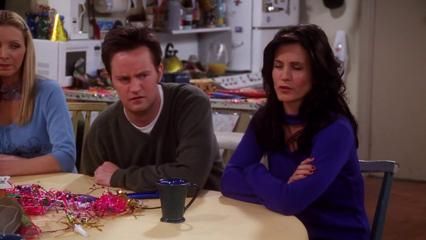
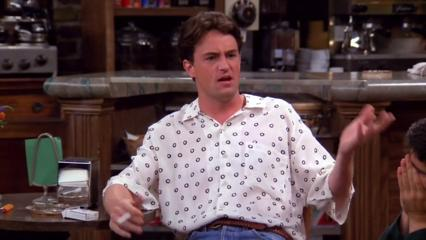
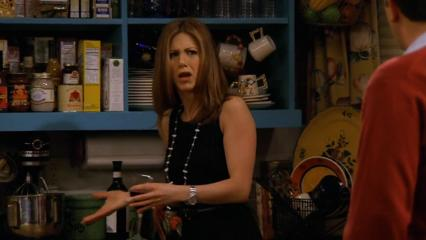
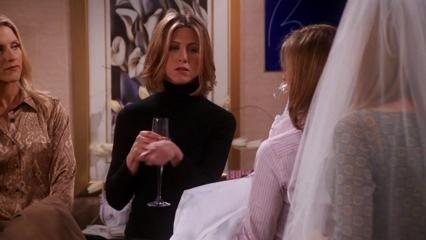
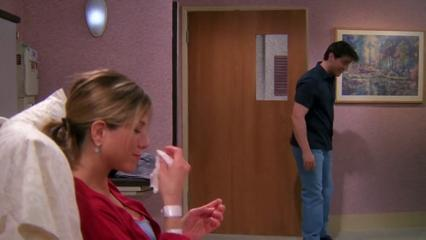
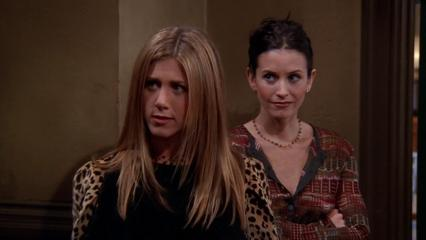
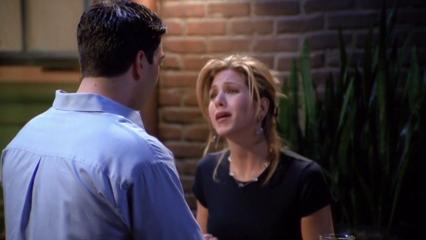
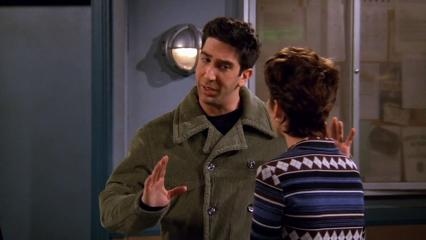
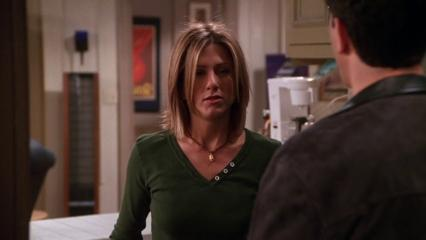
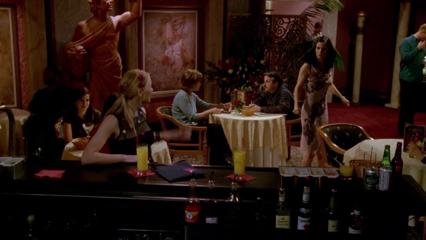
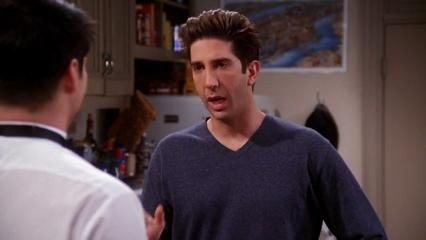
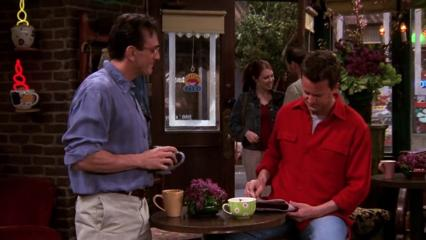
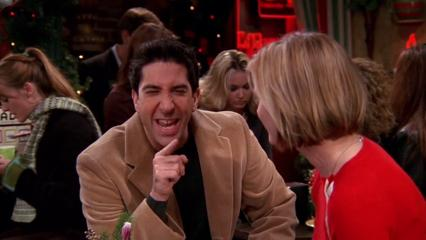
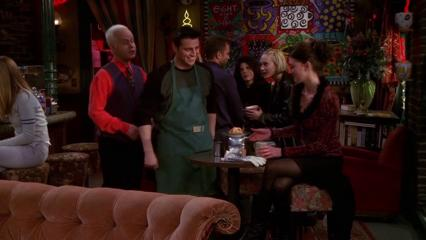
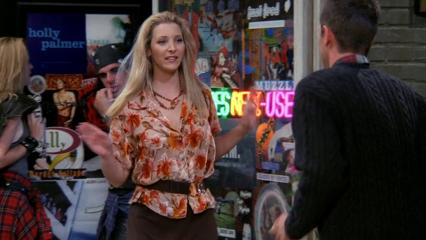
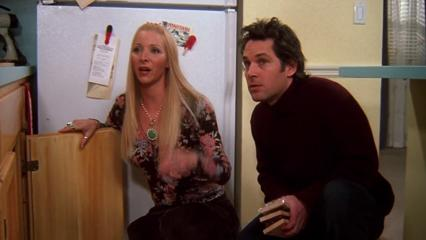
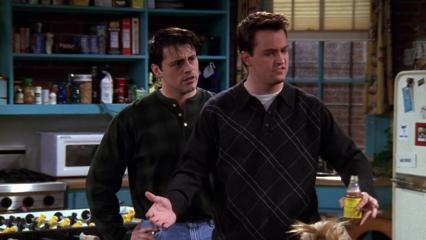
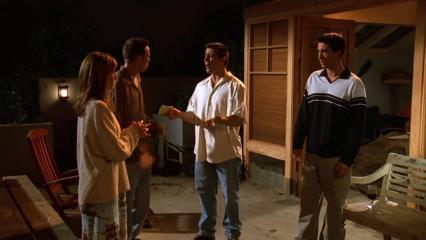
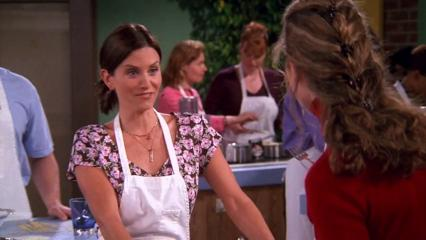
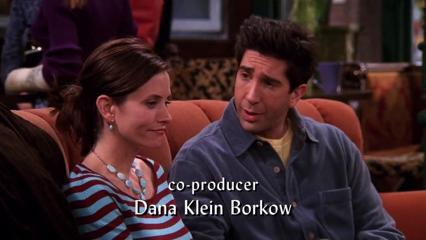
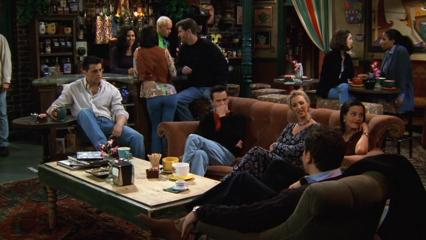

In [10]:
import io
import base64
from IPython.display import display, HTML
from PIL import Image

df_sample = df_raw.groupby(["label"], group_keys=False).apply(lambda x: x.sample(min(len(x), 3)))
df_sample = df_sample.sort_values(["label"])

table_rows = []
for i, row in df_sample.iterrows():
    speaker_cell = f'<td>{row["speaker"]}</td>'
    text_cell = f'<td>{row["x_text"]}</td>'
    image_path = dir_data / row["x_visual"]
    with Image.open(image_path) as img:
        width, height = img.size
        crop_top = height // 2 - height // 10
        crop_bottom = height // 2 + height // 10
        img_cropped = img.crop((0, crop_top, width, crop_bottom))
        buffer = io.BytesIO()
        img_cropped.save(buffer, format="JPEG")
        image_data = base64.b64encode(buffer.getvalue()).decode()
    image_cell = f'<td><img src="data:image/jpeg;base64,{image_data}" width="100"></td>'
    audio_cell = f'<td><audio controls src="{dir_data / row["x_audio"]}" /></td>'
    label_cell = f'<td>{row["label"]}</td>'
    table_rows.append(f"<tr>{speaker_cell}{text_cell}{image_cell}{audio_cell}{label_cell}</tr>")

table_html = (
    "<table><tr><th>Speaker</th><th>Text</th><th>Image</th><th>Audio</th><th>Emotion</th></tr>"
    + "".join(table_rows)
    + "</table>"
)
display(HTML(table_html))

## 3. Statistical Analysis


### 3.1. Basic Data Features

In [11]:
from nltk.tokenize import word_tokenize

pd.DataFrame.from_dict(
    dict(
        max_char_length=max(df_raw.x_text.map(lambda x: len(x))),
        max_token_count=max(df_raw.x_text.map(lambda x: len(word_tokenize(x)))),
        count_label_neutral=len(df_raw[df_raw.label == "neutral"]),
        count_label_joy=len(df_raw[df_raw.label == "joy"]),
        count_label_sadness=len(df_raw[df_raw.label == "sadness"]),
        count_label_fear=len(df_raw[df_raw.label == "fear"]),
        count_label_anger=len(df_raw[df_raw.label == "anger"]),
        count_label_surprise=len(df_raw[df_raw.label == "surprise"]),
        count_label_disgust=len(df_raw[df_raw.label == "disgust"]),
    ),
    orient="index",
)

,0
max_char_length,327
max_token_count,91
count_label_neutral,4710
count_label_joy,1743
count_label_sadness,683
count_label_fear,268
count_label_anger,1109
count_label_surprise,1205
count_label_disgust,271


## 4. Data Visualization


### 4.1. Wordclouds (with & without Stopwords)


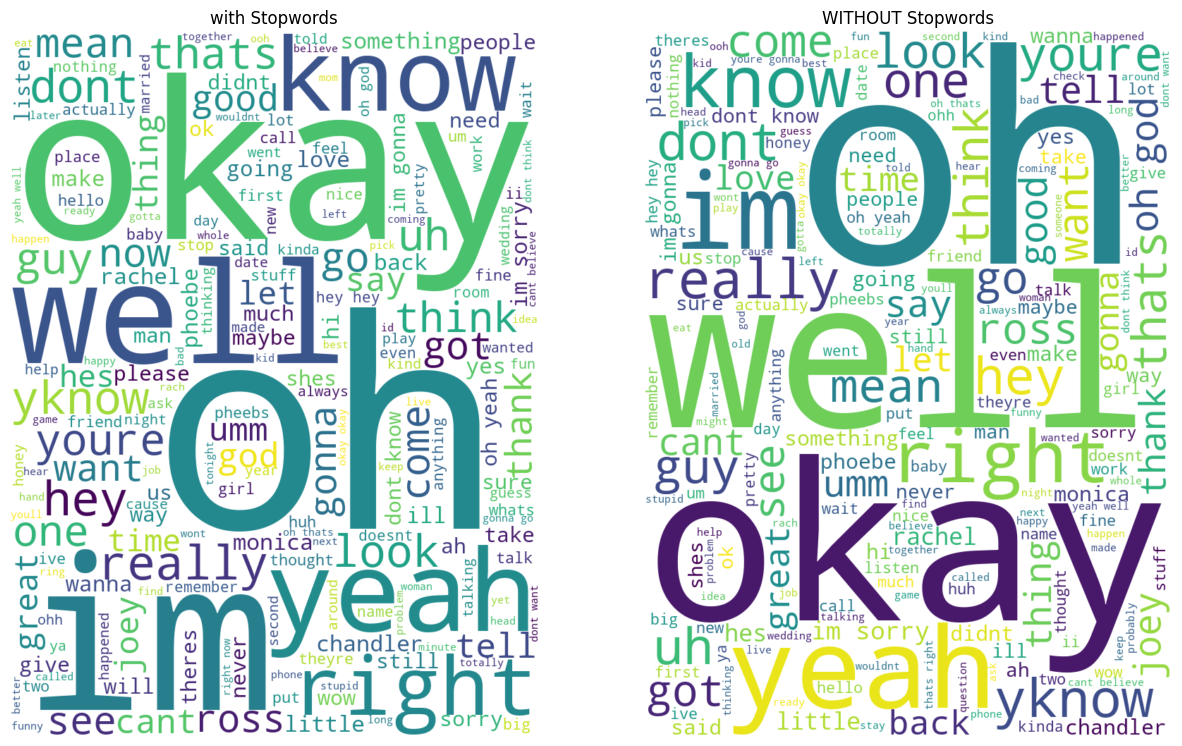

In [12]:
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Get the list of stopwords
stop_words = set(stopwords.words("english"))

# Combine all text into a single string and remove special chars
text = re.sub(r"[^\w\s\d]", "", " ".join(df_raw.x_text.tolist()).lower())

# Generate the word cloud with stopwords
wordcloud_with_stopwords = WordCloud(width=750, height=1000, background_color="white").generate(text)

# Remove stopwords from the text
text_without_stopwords = " ".join([word for word in text.split() if word not in stop_words])

# Generate the word cloud without stopwords
wordcloud_without_stopwords = WordCloud(width=750, height=1000, background_color="white").generate(
    text_without_stopwords
)

# Display the word clouds side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(wordcloud_with_stopwords, interpolation="bilinear")
axs[0].set_title("with Stopwords")
axs[0].axis("off")
axs[1].imshow(wordcloud_without_stopwords, interpolation="bilinear")
axs[1].set_title("WITHOUT Stopwords")
axs[1].axis("off")
plt.show()

### 4.2. Sentence Length Distribution

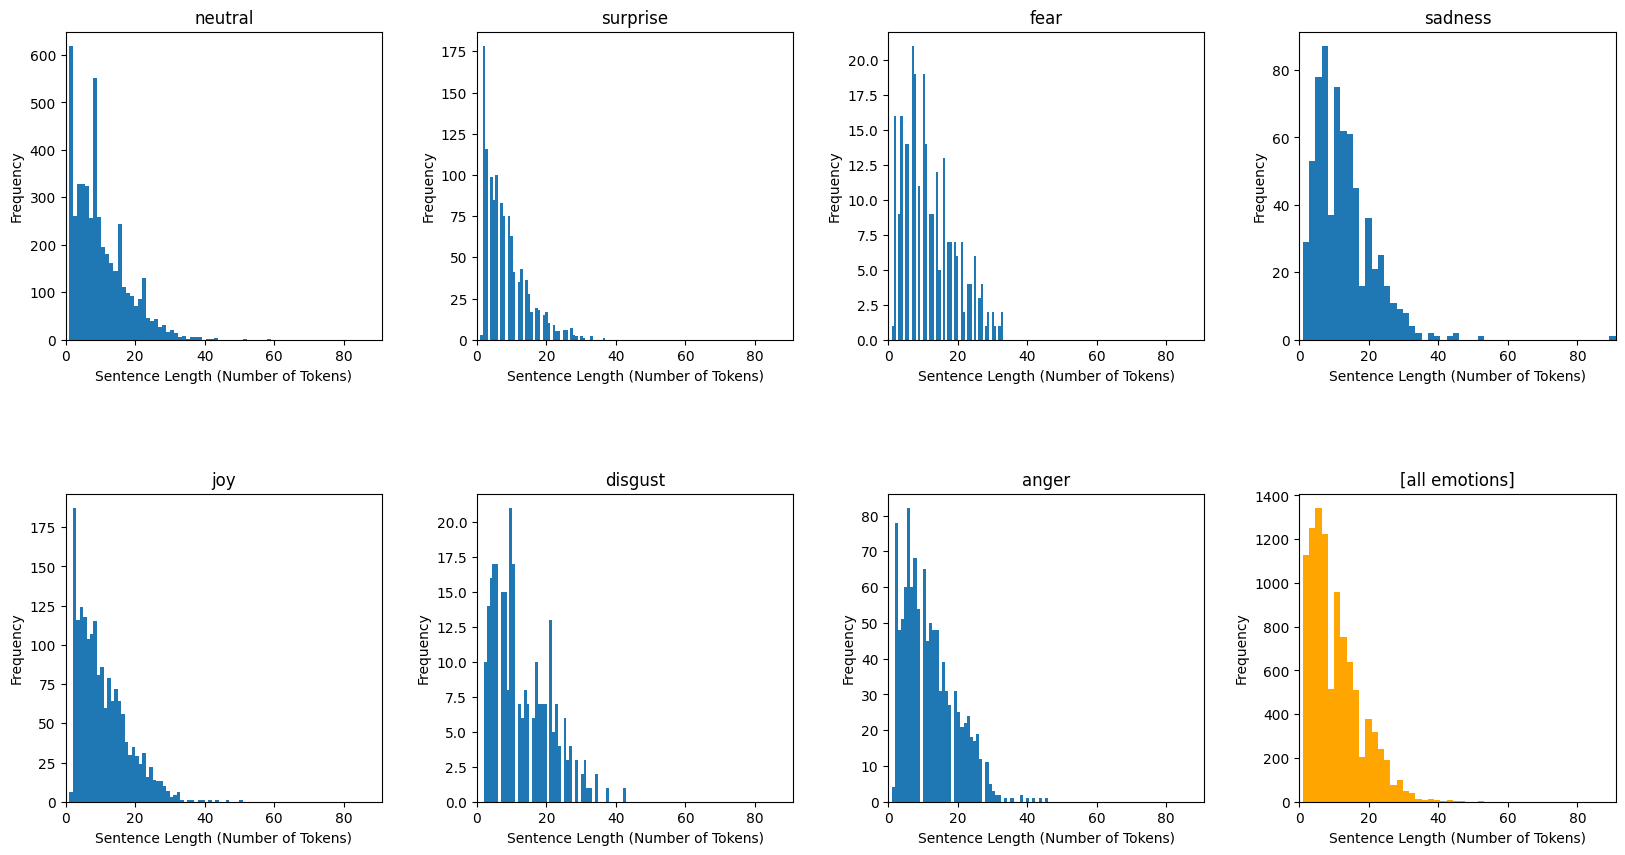

In [13]:
import matplotlib.pyplot as plt
import nltk

# Tokenize the sentences using the nltk tokenizer
df_raw["tokens"] = df_raw["x_text"].apply(nltk.word_tokenize)
df_raw["sentence_length"] = df_raw["tokens"].apply(len)

# Get the unique emotion labels
labels = df_raw["label"].unique()

# Create a grid of histograms
num_rows = (len(labels) + 3) // 4
fig, axs = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
for i, label in enumerate(labels):
    # Filter the data by label
    df = df_raw[df_raw["label"] == label]["sentence_length"]

    # Plot the histogram
    axs[i // 4, i % 4].hist(df, bins=50)
    axs[i // 4, i % 4].set_title(label)
    axs[i // 4, i % 4].set_xlabel("Sentence Length (Number of Tokens)")
    axs[i // 4, i % 4].set_ylabel("Frequency")

    # Set the x-axis limit to the maximum sentence length
    axs[i // 4, i % 4].set_xlim([0, df_raw["sentence_length"].max()])

# Plot the combined distribution
df = df_raw["sentence_length"]
axs[-1, -1].hist(df, bins=50, color="orange")
axs[-1, -1].set_title("[all emotions]")
axs[-1, -1].set_xlabel("Sentence Length (Number of Tokens)")
axs[-1, -1].set_ylabel("Frequency")
axs[-1, -1].set_xlim([0, df_raw["sentence_length"].max()])

# Remove the unused subplots
for i in range(len(labels) + 1, num_rows * 4):
    axs.flat[i].set_visible(False)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Show the plot
plt.show()

### 4.3. LDA-based Topic Modelling

In [14]:
import logging
import pyLDAvis.gensim_models
import gensim
import nltk
import re
from nltk.corpus import stopwords

# Set the logging level to WARNING
gensim.models.ldamodel.logger.setLevel(logging.WARNING)

# Tokenize the sentences using the nltk tokenizer, lowercase them, remove special chars and remove stopwords
stop_words = set(stopwords.words("english"))
utterances = [re.sub(r"[^\w\s\d]", "", utterance) for utterance in df_raw["x_text"]]
tokens = [nltk.word_tokenize(x) for x in utterances]
tokens = [[word.lower() for word in sentence] for sentence in tokens]
tokens = [[word for word in sentence if word not in stop_words] for sentence in tokens]

# Create a dictionary from the tokens
dictionary = gensim.corpora.Dictionary(tokens)

# Create a bag-of-words corpus from the dictionary and tokens
corpus = [dictionary.doc2bow(sentence) for sentence in tokens]

# Train the LDA model on the corpus
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=42,
    passes=10,
    per_word_topics=True,
)

# Create an interactive visualization of the topics and their associated keywords
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:built Dictionary<5762 unique tokens: ['also', 'companys', 'gr6', 'kl5', 'person']...> from 9989 documents (total 42452 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<5762 unique tokens: ['also', 'companys', 'gr6', 'kl5', 'person']...> from 9989 documents (total 42452 corpus positions)", 'datetime': '2023-08-01T17:49:30.608755', 'gensim': '4.3.1', 'python': '3.10.11 (main, Jun  6 2023, 22:40:11) [Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.6.8-x86_64-i386-64bit', 'event': 'created'}
INFO:gensim.utils:LdaModel lifecycle event {'msg': 'trained LdaModel<num_terms=5762, num_topics=10, decay=0.5, chunksize=2000> in 17.65s', 'datetime': '2023-08-01T17:49:48.371559', 'gensim': '4.3.1', 'python': '3.10.11 (main, Jun  6 2023, 22:40:11) [Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.6.8-x86_64-i386-64bit', 'even

### 4.4. 3D PCA & UMAP Embeddings Representations

In [15]:
import torch
import tensorflow_hub as hub
import torchvision.transforms as transforms
from transformers import AutoTokenizer, AutoModel

# Loading USE4
use4_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Loading SimCSE
simcse_model_name = "ZurichNLP/unsup-simcse-xlm-roberta-base"
simcse_tokenizer = AutoTokenizer.from_pretrained(simcse_model_name)
simcse_model = AutoModel.from_pretrained(simcse_model_name)

# Loading ResNet50
resnet50_model = torch.hub.load("pytorch/vision:v0.9.0", "resnet50", pretrained=True)
resnet50_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.2706, 0.2010, 0.1914], std=[0.1857, 0.1608, 0.1667]),
    ]
)

2023-08-01 17:50:08.530547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
  from .autonotebook import tqdm as notebook_tqdm

INFO:absl:Using /var/folders/gt/j16393sd52s3xsm_3fsd_3qr0000gn/T/tfhub_modules to cache modules.
INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/gt/j16393sd52s3xsm_3fsd_3qr0000gn/T/tmp22f82e0x
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/gt/j16393sd52s3xsm_3fsd_3qr0000gn/T/tmp22f82e0x/_remote_module_non_scriptable.py
  if not hasattr(tensorboard, "__version__") or LooseVersion(

  ) < LooseVersion("1.15"):

Some weights of XLMRobertaModel were not initialized from the model checkpoint at ZurichNLP/unsup-

In [16]:
import itertools
import numpy as np
import pandas as pd
import umap
import torch
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
from PIL import Image
from sklearn.decomposition import PCA
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

  @numba.jit()

  @numba.jit()

  @numba.jit()

  @numba.jit()



In [17]:
%env TOKENIZERS_PARALLELISM=True

env: TOKENIZERS_PARALLELISM=True


In [18]:
def get_embeddings(df, p, emb_fn, bsz, desc):
    embeddings = []
    for i in tqdm(range(0, len(df), bsz), desc=desc):
        batch = list(df[p][i : i + bsz])
        batch = emb_fn(batch)
        embeddings.append(batch)
    embeddings = list(itertools.chain(*[e.tolist() for e in embeddings]))
    embeddings = pad_sequences(embeddings, dtype="float32", padding="post")
    return embeddings

In [19]:
def plot_3d_embeddings_pca_using(
    ax,
    title: str,
    df: pd.DataFrame,
    p: str,
    embeddings,
):
    # Perform PCA on the normalized embeddings to reduce them to 3 dimensions
    pca = PCA(n_components=3)
    pca_embeddings = pca.fit_transform(embeddings)

    # Normalize the embeddings to lie on the surface of the unit sphere
    norms = np.linalg.norm(pca_embeddings, axis=1, keepdims=True)
    normalized_embeddings = pca_embeddings / norms

    # Create a 3D scatter plot of the PCA embeddings, color-coded by label
    colors = dict(
        neutral="gray",
        surprise="yellow",
        fear="black",
        sadness="blue",
        joy="green",
        disgust="purple",
        anger="red",
    )
    for i, label in enumerate(list(df.label)):
        ax.scatter(
            normalized_embeddings[i, 0],
            normalized_embeddings[i, 1],
            normalized_embeddings[i, 2],
            c=colors[label],
        )

    ax.set_title(title)

In [20]:
def plot_3d_embeddings_umap_using(
    ax,
    title: str,
    df: pd.DataFrame,
    p: str,
    embeddings,
):
    # Perform UMAP on the embeddings to reduce them to 3 dimensions
    umap_embeddings = umap.UMAP(n_components=3).fit_transform(embeddings)

    # Create a 3D scatter plot of the UMAP embeddings, color-coded by label
    colors = dict(
        neutral="gray",
        surprise="yellow",
        fear="black",
        sadness="blue",
        joy="green",
        disgust="purple",
        anger="red",
    )
    for i, label in enumerate(list(df.label)):
        ax.scatter(
            umap_embeddings[i, 0],
            umap_embeddings[i, 1],
            umap_embeddings[i, 2],
            c=colors[label],
        )

    ax.set_title(title)

In [21]:
# USE4 Embeddings
def embedding_fn_use4(x):
    return use4_model(x)


# SimCSE Embeddings
def embedding_fn_simcse(x):
    inputs = simcse_tokenizer(x, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = simcse_model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.numpy()


# ResNet50 Embeddings
def embedding_fn_resnet50(image_paths):
    img_tensors = []
    for image_path in image_paths:
        img = Image.open(str(dir_data / image_path))
        img_tensor = resnet50_transforms(img)
        img_tensor = img_tensor.unsqueeze(0)
        img_tensors.append(img_tensor)
    with torch.no_grad():
        embeddings = resnet50_model(torch.cat(img_tensors, dim=0))
    embeddings = torch.nn.functional.normalize(embeddings, dim=1).squeeze(0)
    return embeddings.numpy()


# MEL Feature Audio Embeddings
def embedding_fn_audiomel(audio_paths):
    embeddings = []
    for audio_path in audio_paths:
        y, sr = librosa.load(str(dir_data / audio_path), sr=16000)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max).flatten()
        embeddings.append(log_mel_spec)
    embeddings = pad_sequences(embeddings, padding="post", dtype="float32")
    return embeddings

AudioMEL:  69%|██████▉   | 38/55 [00:19<00:07,  2.21it/s]WARNING:py.warnings:/Users/hudsonmendes/Workspaces/universityoflondon/cm3070-fp/venv/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1760
  warnings.warn(

AudioMEL: 100%|██████████| 55/55 [00:27<00:00,  1.97it/s]


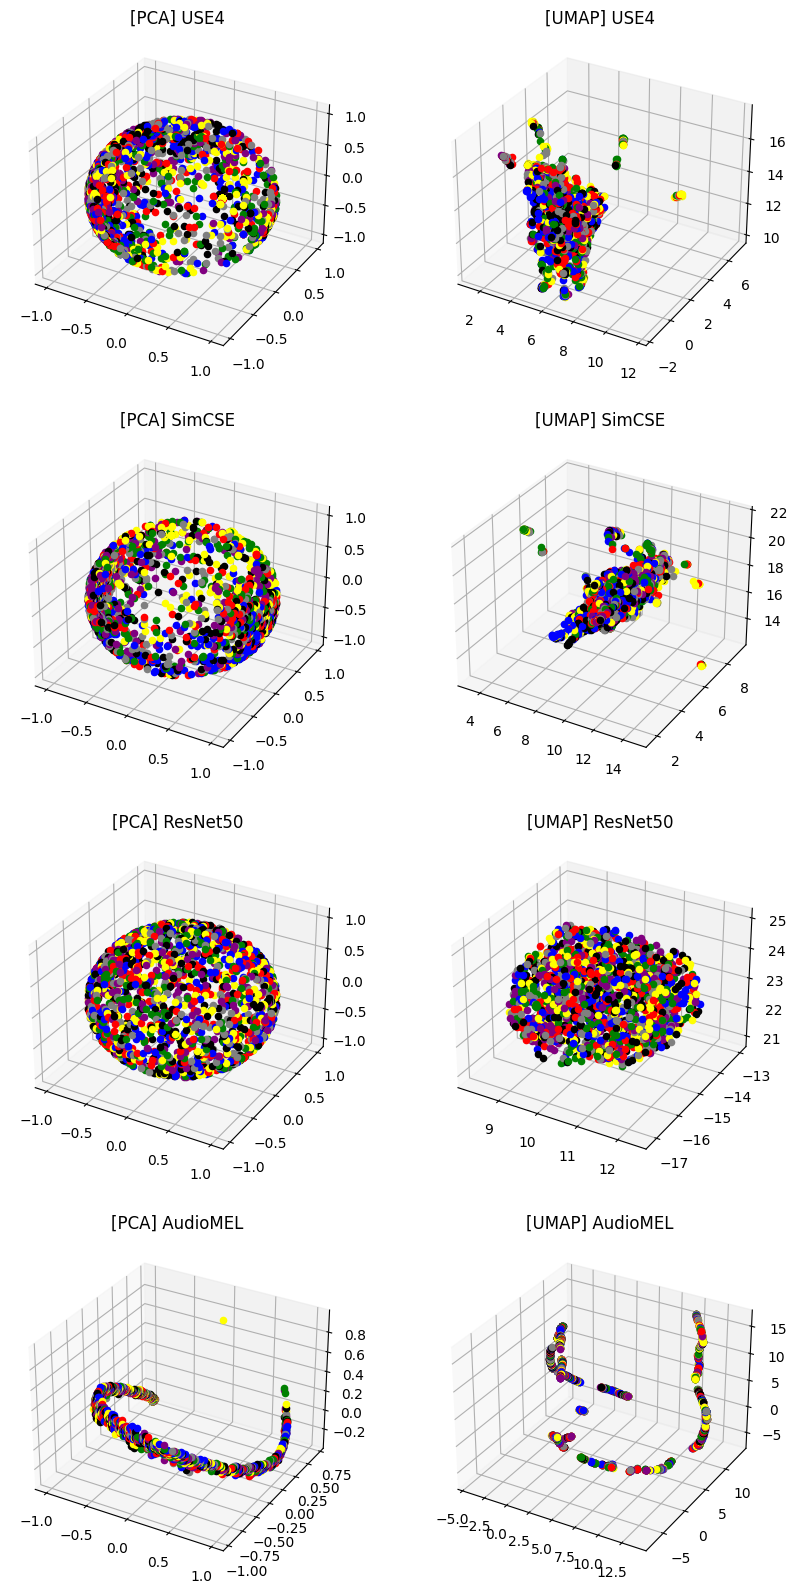

In [25]:
# Defining the sample
df_sample = df_raw.groupby("label").apply(lambda x: x.sample(n=250)).reset_index(drop=True)

# Collecting embeddings
use4_embeddings = get_embeddings(df_sample, "x_text", embedding_fn_use4, 64, "USE4")
simcse_embeddings = get_embeddings(df_sample, "x_text", embedding_fn_simcse, 16, "SimCSE")
resnet50_embeddings = get_embeddings(df_sample, "x_visual", embedding_fn_resnet50, 4, "ResNet50")
audiomel_embeddings = get_embeddings(df_sample, "x_audio", embedding_fn_audiomel, 32, "AudioMEL")

# Plotting PCA and UMAP Embeddings in 3D
fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(4, 2, 1, projection="3d")
ax2 = fig.add_subplot(4, 2, 2, projection="3d")
ax3 = fig.add_subplot(4, 2, 3, projection="3d")
ax4 = fig.add_subplot(4, 2, 4, projection="3d")
ax5 = fig.add_subplot(4, 2, 5, projection="3d")
ax6 = fig.add_subplot(4, 2, 6, projection="3d")
ax7 = fig.add_subplot(4, 2, 7, projection="3d")
ax8 = fig.add_subplot(4, 2, 8, projection="3d")
plot_3d_embeddings_pca_using(ax1, title="[PCA] USE4", df=df_sample, p="x_text", embeddings=use4_embeddings)
plot_3d_embeddings_pca_using(ax3, title="[PCA] SimCSE", df=df_sample, p="x_text", embeddings=simcse_embeddings)
plot_3d_embeddings_pca_using(ax5, title="[PCA] ResNet50", df=df_sample, p="x_visual", embeddings=resnet50_embeddings)
plot_3d_embeddings_pca_using(ax7, title="[PCA] AudioMEL", df=df_sample, p="x_audio", embeddings=audiomel_embeddings)
plot_3d_embeddings_umap_using(ax2, title="[UMAP] USE4", df=df_sample, p="x_text", embeddings=use4_embeddings)
plot_3d_embeddings_umap_using(ax4, title="[UMAP] SimCSE", df=df_sample, p="x_text", embeddings=simcse_embeddings)
plot_3d_embeddings_umap_using(ax6, title="[UMAP] ResNet50", df=df_sample, p="x_visual", embeddings=resnet50_embeddings)
plot_3d_embeddings_umap_using(ax8, title="[UMAP] AudioMEL", df=df_sample, p="x_audio", embeddings=audiomel_embeddings)
plt.show()

## References

[1] Poria, Soujanya, et al. ‘MELD: A Multimodal Multi-Party Dataset for Emotion Recognition in Conversations’. ArXiv [Cs.CL], 2019, http://arxiv.org/abs/1810.02508. arXiv.

[2] Chen, Sheng-Yeh, et al. ‘EmotionLines: An Emotion Corpus of Multi-Party Conversations’. ArXiv [Cs.CL], 2018, http://arxiv.org/abs/1802.08379. arXiv.

